In [113]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import measure, morphology

Text(0.5, 1.0, 'B')

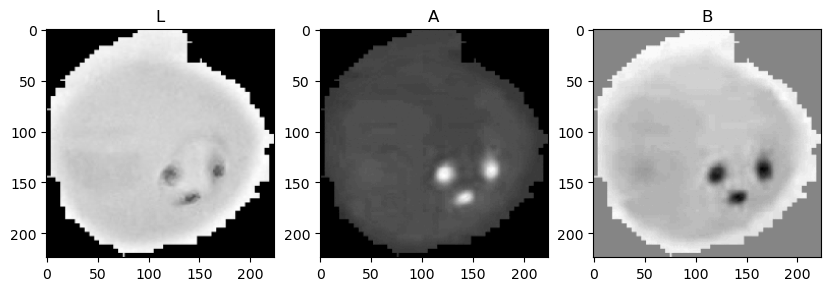

In [114]:
# Carico l'immagine in RGB
image = Image.open('FESI/Progetto/malaria/malaria/parasite (1).png').convert("RGB")
image_array = np.array(image) 

# Converto l'immagine da RGB a LAB e ridimensionamento 

scaled_image = cv2.resize(image_array, (224, 224), interpolation=cv2.INTER_AREA)

image_lab = cv2.cvtColor(scaled_image, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(image_lab)

# Normalizzazione della luminosità
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
l_clahe = clahe.apply(l)

# Rimozione del rumore (opzionale)
l_smooth = cv2.GaussianBlur(l_clahe, (5, 5), 0)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(l, cmap="gray")
plt.title("L")

plt.subplot(1,3,2)
plt.imshow(a, cmap="gray")
plt.title("A")

plt.subplot(1,3,3)
plt.imshow(b, cmap="gray")
plt.title("B")

Text(0.5, 1.0, 'ThresHold')

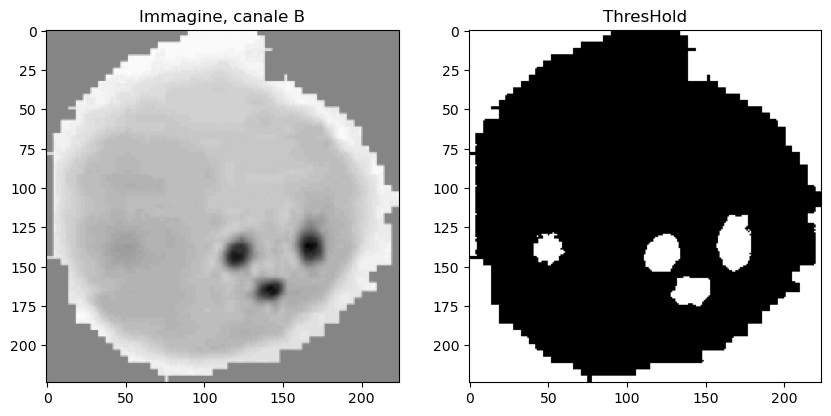

In [115]:
# Threshold using OTSU
ret, thresh = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(b, cmap="gray")
plt.title("Immagine, canale B")

plt.subplot(1,2,2)
plt.imshow(thresh, cmap="gray")
plt.title("ThresHold")

Text(0.5, 1.0, 'ThresHold, No noise')

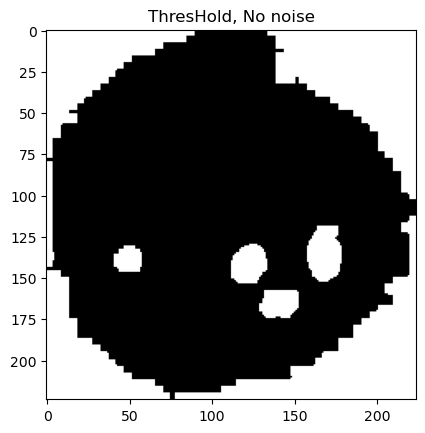

In [116]:
# noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations = 2)

plt.imshow(opening, cmap="gray")
plt.title("ThresHold, No noise")

Text(0.5, 1.0, 'unknown')

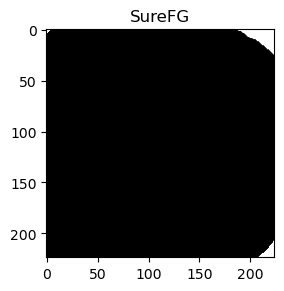

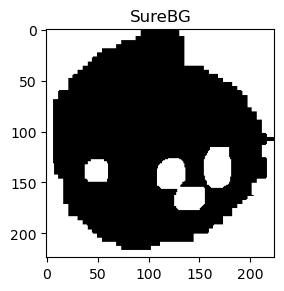

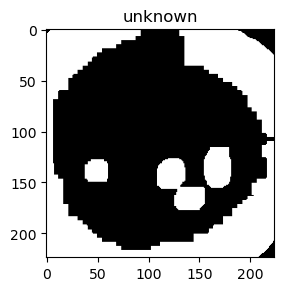

In [117]:
# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.imshow(sure_fg, cmap="gray")
plt.title("SureFG")

plt.figure(figsize=(10, 5))
plt.subplot(1,3,2)
plt.imshow(sure_bg, cmap="gray")
plt.title("SureBG")

plt.figure(figsize=(10, 5))
plt.subplot(1,3,3)
plt.imshow( unknown, cmap="gray")
plt.title("unknown")

Text(0.5, 1.0, 'Result')

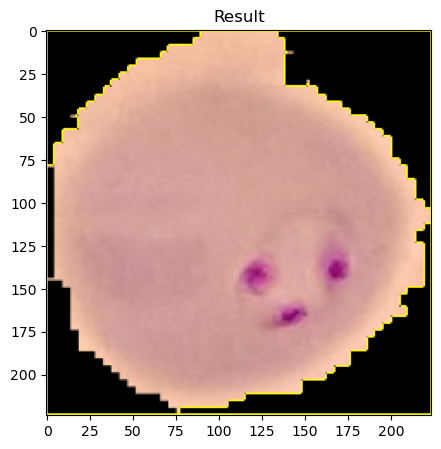

In [118]:

# Marker labelling
# Connected Components determines the connectivity of blob-like regions in a binary image.
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(scaled_image,markers)
scaled_image[markers == -1] = [255,255,0]

plt.figure(figsize=(10, 5))
plt.imshow(scaled_image)
plt.title("Result")
